In [0]:
!pip install pydotplus graphviz

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz

%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Для отрисовки графиков в повышенном качестве

# Для отрисовки деревьев
import pydotplus
from IPython.display import Image

# 5.1 Решающие деревья

## Решающее дерево
Решающее дерево (дерево решений) $-$ это функция от объекта в его признаковом описании. Ее значение вычисляется путем прохода некоторого дерева от корня к листу. Переход по дереву происходит путем принятия решения в узле дерева. 

<img src="https://upload.wikimedia.org/wikipedia/ru/thumb/c/c4/CART_tree_titanic_survivors_%28RU%29.svg/360px-CART_tree_titanic_survivors_%28RU%29.svg.png" alt="Drawing" style="height: 300px;"/>

За счет такого представления результат дерева возможно проинтерпретировать.   
Например, согласно дереву, которое построенно по данным о пассажирах Титаника, значение __выжил__ принимается согласно логическому условию:  
(`пол != "мужской") | ((Пол == "мужской") & (Возраст > 9.5) & (Родств. > 2.5))`.

## Решающие деревья для классификации
Давайте попробуем классифицировать точки на плоскости.

In [0]:
n_points = 500

np.random.seed(42)
x = np.vstack([np.random.normal(loc=1, size=(n_points, 2)),
               np.random.normal(loc=-1, size=(n_points, 2))])
y = np.array([0] * n_points + [1] * n_points)

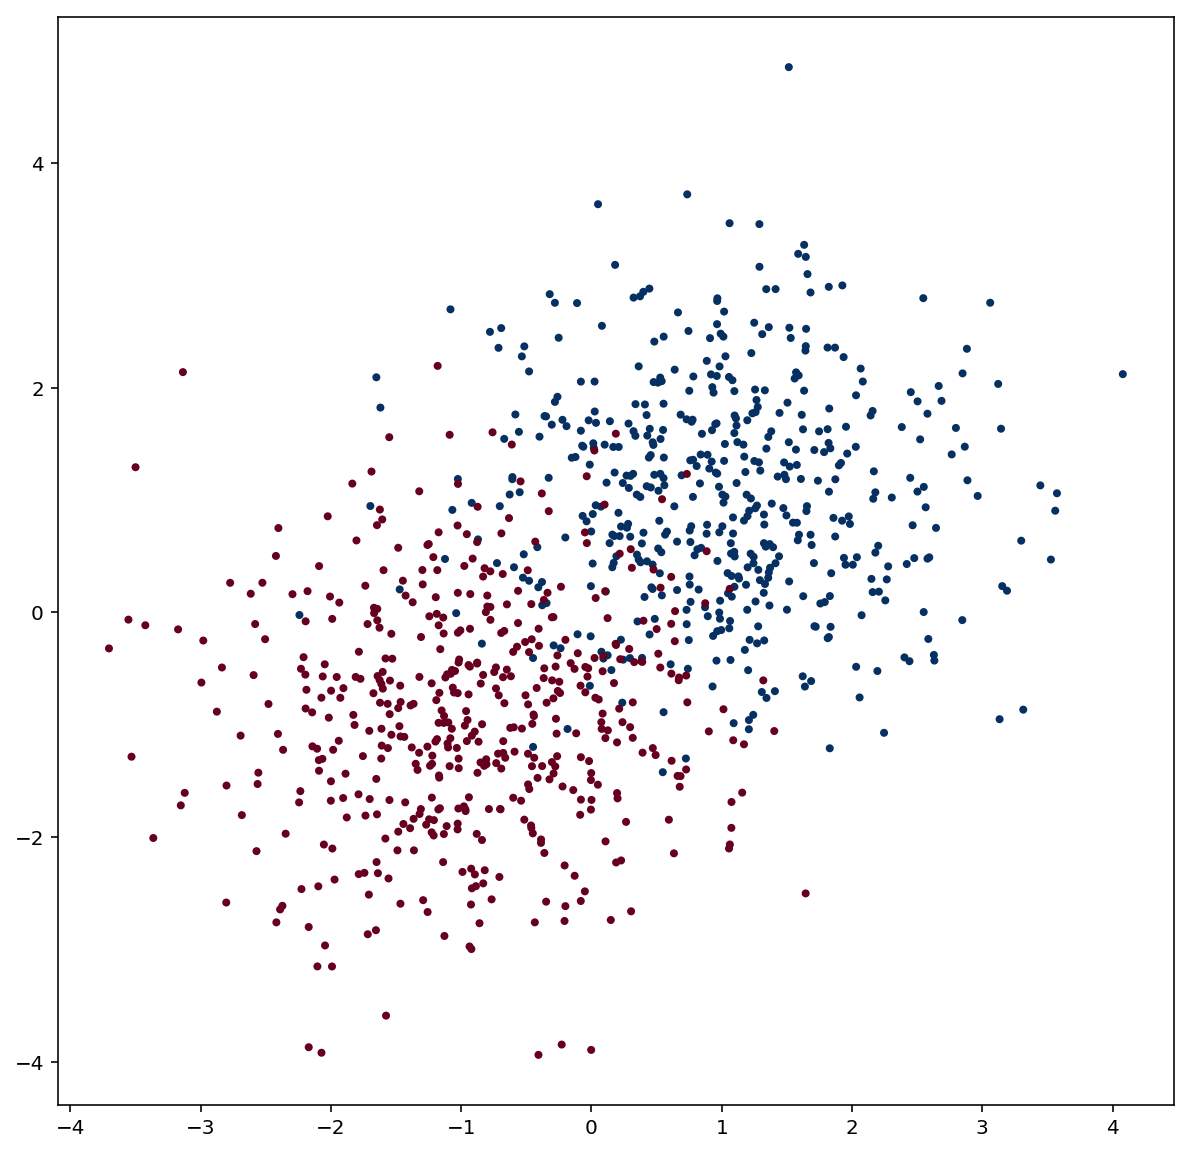

In [0]:
plt.figure(figsize=(10.0, 10.0))
plt.scatter(x[:, 0], x[:, 1], c=y, s=9, cmap=plt.cm.RdBu_r);

Следующие функции рисуют разделяющую поверхность модели и структуру дерева.

In [0]:
def plot_predictions(X, y, clf, proba=False, points_size=9):
    """Fits the classifier on the data (X, y) and plots the result on a 2-D plane."""
    def get_grid(data):
        x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
        y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
        return np.meshgrid(np.arange(x_min, x_max, 0.01),
                           np.arange(y_min, y_max, 0.01))
    
    clf.fit(X, y)
    xx, yy = get_grid(X)
    if proba:
        predicted = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1].reshape(xx.shape)
    else:
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
    plt.figure(figsize=(10.0, 10.0))
    plt.pcolormesh(xx, yy, predicted, cmap=plt.cm.RdBu_r, alpha=0.1)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=points_size, cmap=plt.cm.RdBu_r, alpha=0.90)
    plt.ylim([yy.min(),yy.max()])
    plt.xlim([xx.min(),xx.max()])
    plt.xlabel('x')
    plt.ylabel('y')
    
    return clf

def plot_tree(model, features, max_depth, out_file='tree.tmp'):
    dot_data = export_graphviz(decision_tree=model, out_file=out_file,
                               max_depth=max_depth, feature_names=features,
                               class_names=['0', '1'], filled=True, rounded=True,
                               special_characters=True,
                               proportion = True, precision=2,
                               label='all', impurity=False)  

    graph = pydotplus.graphviz.graph_from_dot_file(out_file)  
    return Image(graph.create_png())

Обучим дерево и посмотрим на него.

In [0]:
tree = DecisionTreeClassifier(min_samples_leaf=100)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=100, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

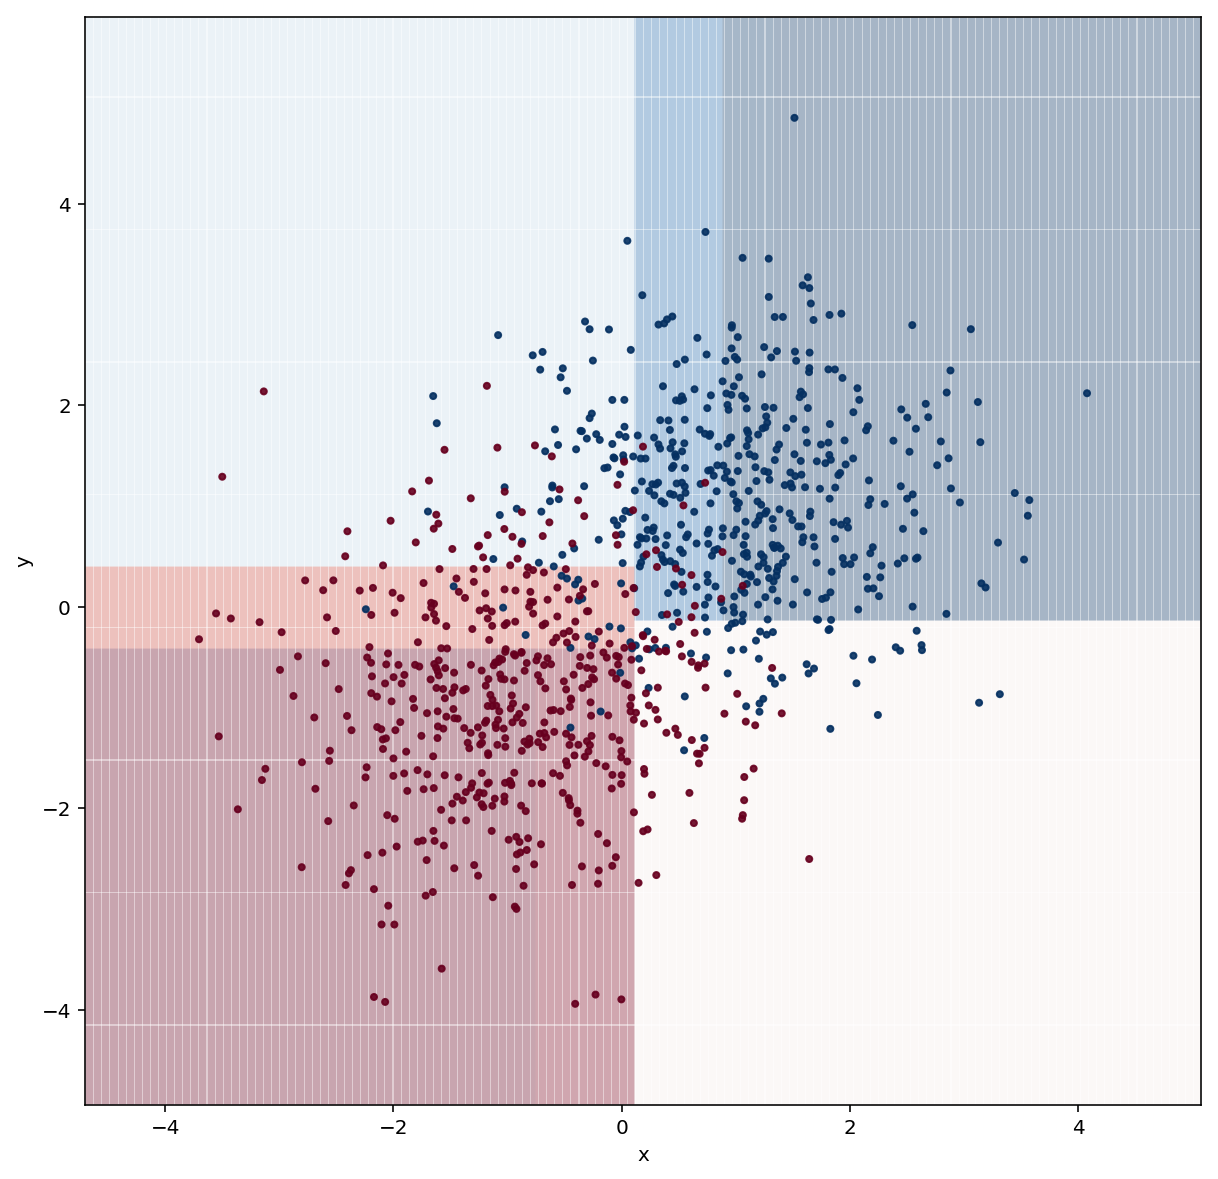

In [0]:
plot_predictions(x, y, tree, proba=True)

Если задать параметр `max_depth = None`, то видно что дерево переобучается: разделяющая поверхность строится на основе объектов-выбросов. Для борьбы с этим существуют несколько методов:
* ограничение структуры дерева: при построении дерево подчиняется ряду правил, например
    * ограничена максимальная высота (`max_depth`)
    * в листьях должно присутствовать как минимум какое-то число объектов (`min_samples_leaf`)
* усечение дерева: отрезание плохих вершин дерева  
Все эти методы эвристические и их качество борьбы с переобучением зависит от конкретных данных.

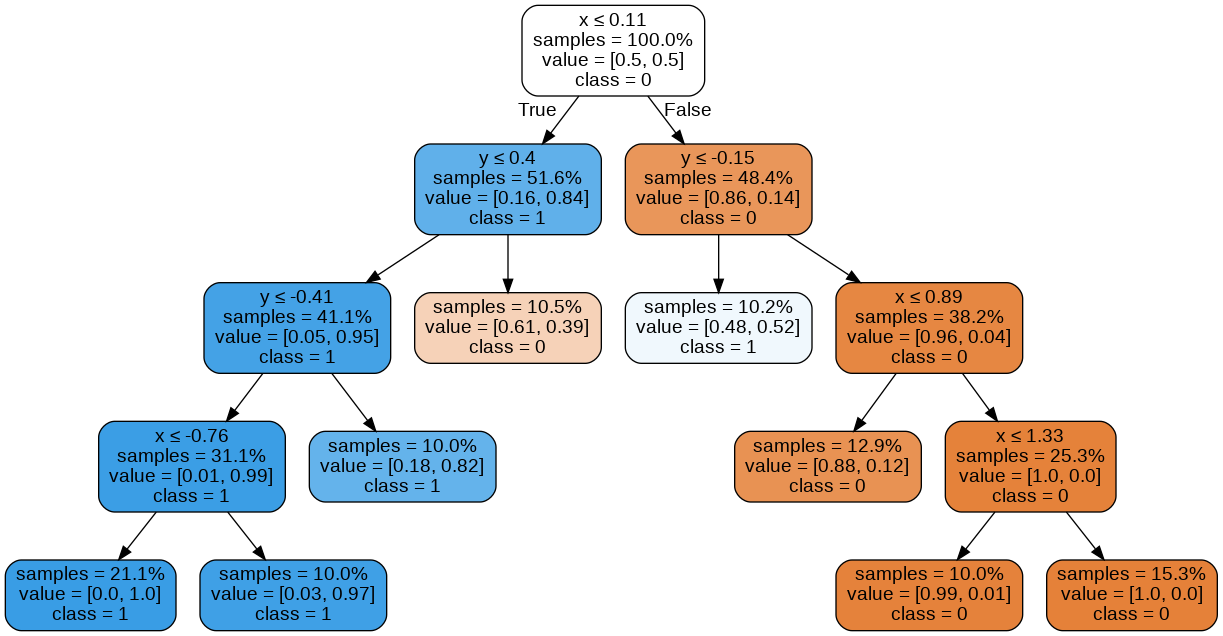

In [0]:
plot_tree(tree, ['x', 'y'], max_depth=4)

## Решающие деревья для регрессии
Решающие деревья могут в том числе быть использованы для решения задачи регрессии. В таком случае они представляют собой кусочно-постоянную функцию.

In [0]:
x = np.linspace(-10, 10, num=100).reshape(-1, 1)
y = (x ** 2) * np.sin(x)

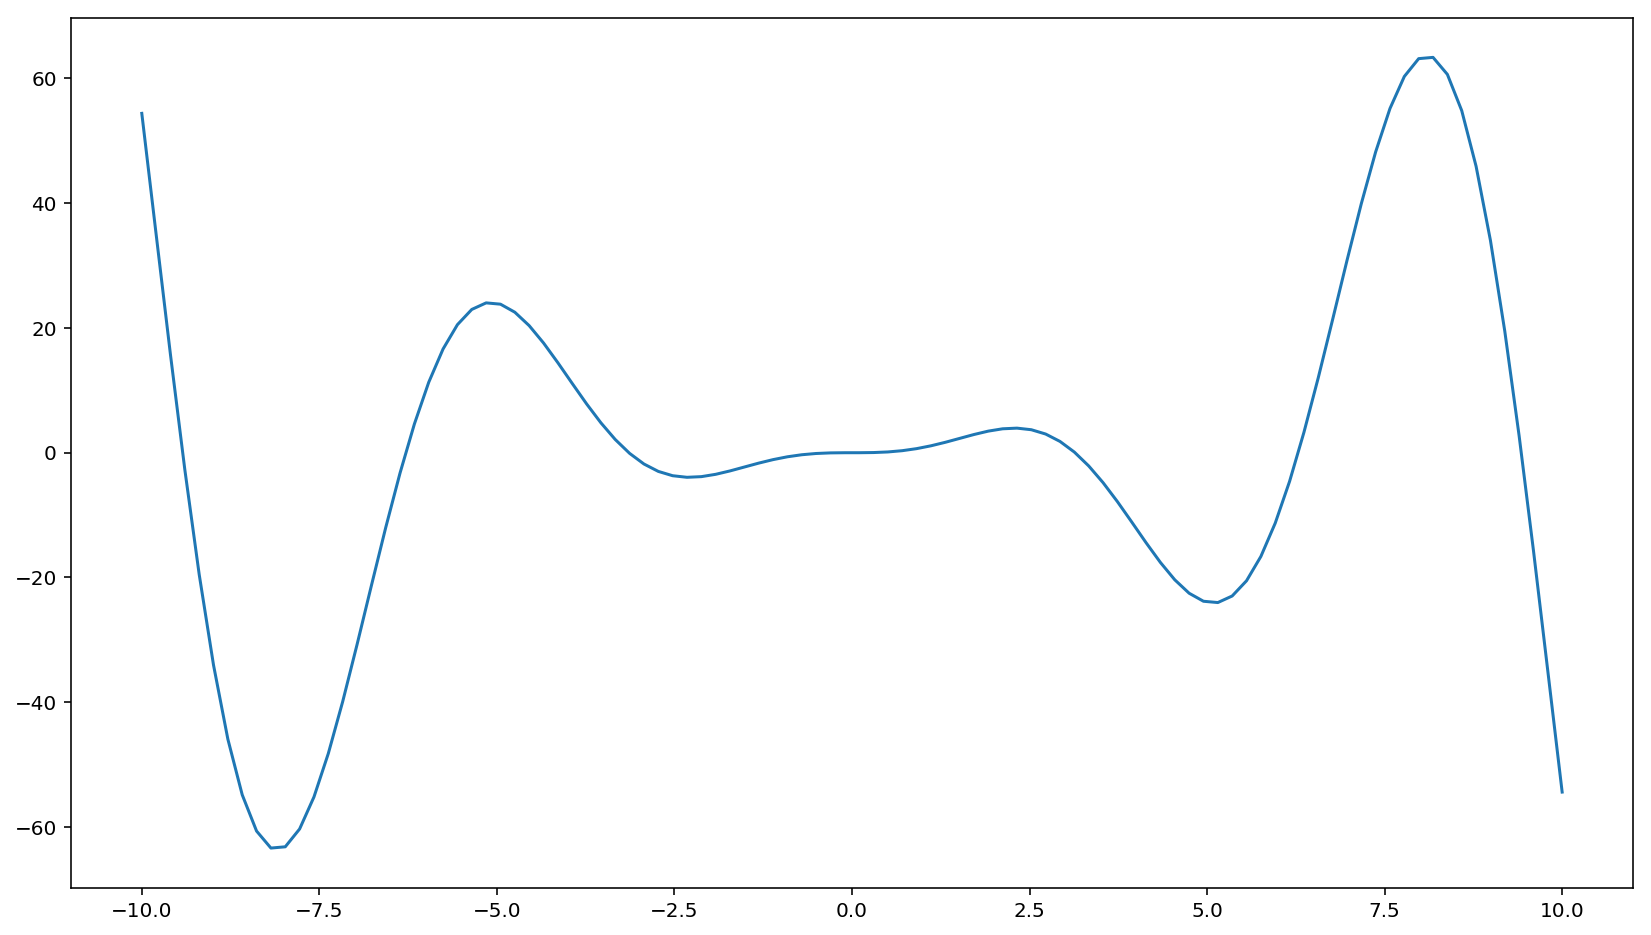

In [0]:
plt.figure(figsize=(14.0, 8.0))
plt.plot(x, y);

In [0]:
def plot_regressor_as_function(reg, x, y):
    reg.fit(x, y)
    
    plt.figure(figsize=(14.0, 8.0))
    plt.plot(x, y, '.')
    plt.plot(x, reg.predict(x))    

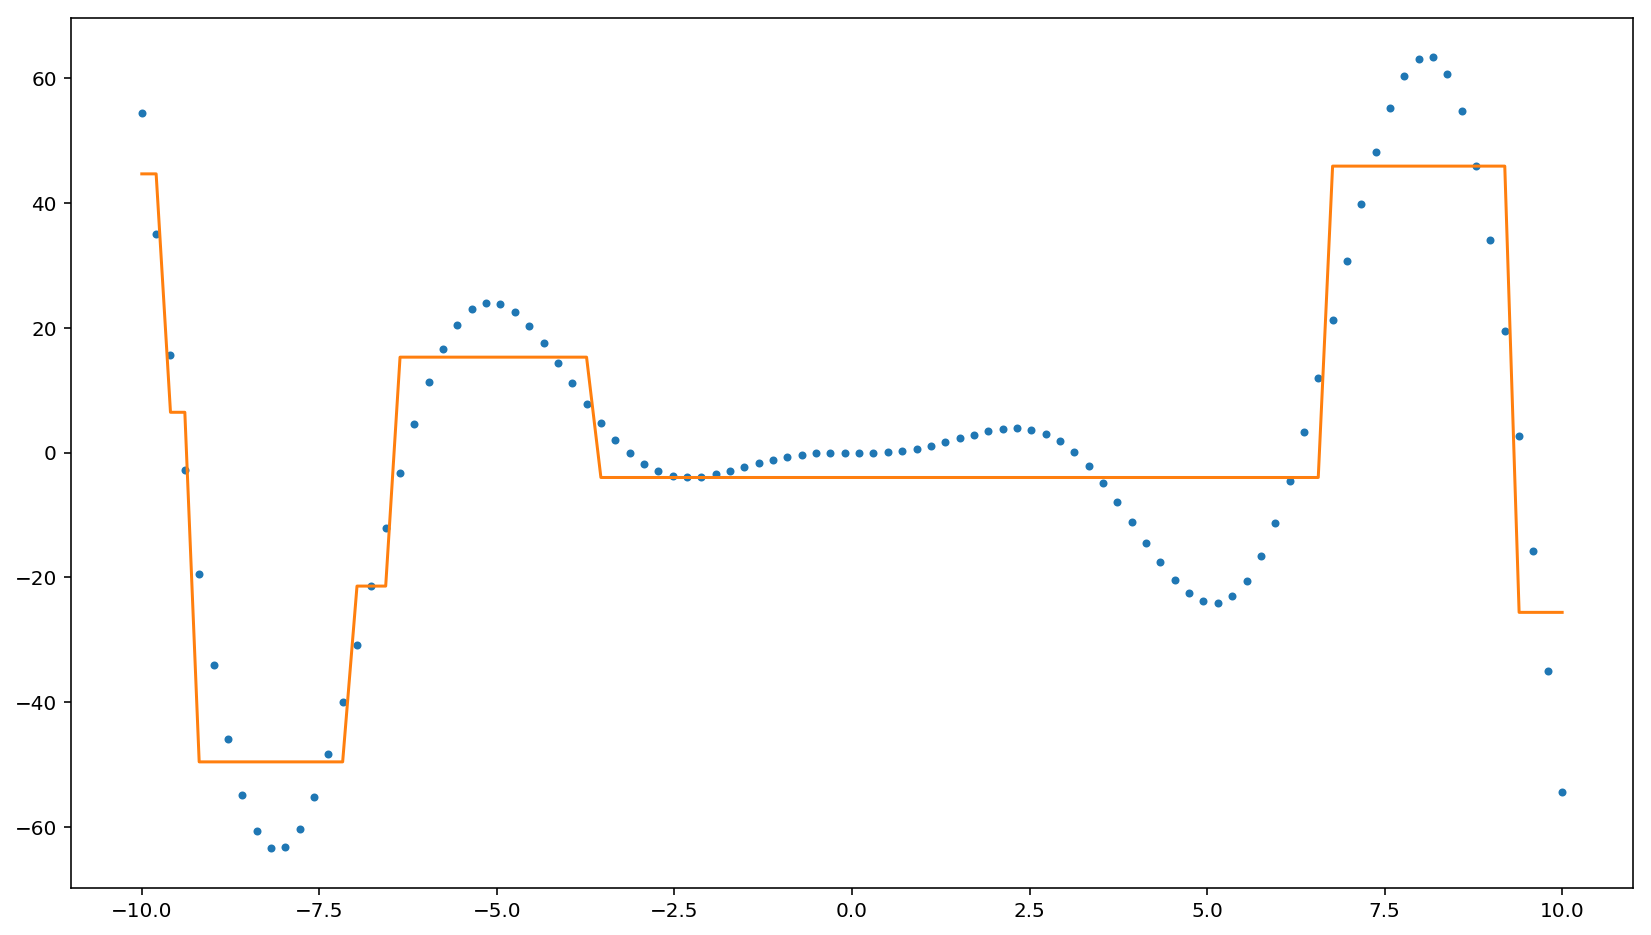

In [0]:
reg = DecisionTreeRegressor(max_depth=3)
plot_regressor_as_function(reg, x, y)

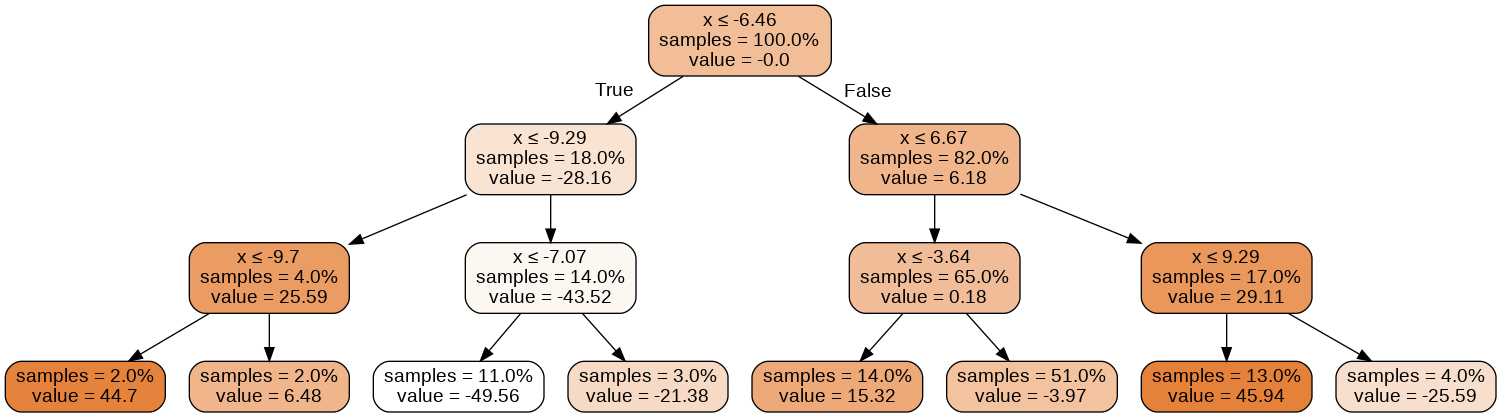

In [0]:
plot_tree(reg, ['x'], max_depth=30)

# Построение решающего дерева

Для описания алгоритма потребуется несколько определений.

__Критерий информативности__ $-$ это величина, определенная для значений из обучающей выборки, попавших в лист дерева. Говорит о том, насколько хорошо в работает предикат в этом листе. Рассмотрим некоторые из них.

*__Энтропия.__*  Это статистическая величина, измеряющая однорость данных. Низкая энтропия означает, что данные однородные, высокая $-$ что разнообразные. Она считается по следующей формуле.
 $$H(R)=\sum_{x \in X}{-p_R(x)\log_2 p_R(x)}$$
 $R$ $-$ данные  
 $X$ $-$ множество возможных значений данных  
 $p_R(x)$ $-$ частота $x$ в $R$
 
_Пример_:  
 Пусть в данных 0 встретился 1 раз, 1 встретилась 99 раз. Тогда энтропия равна
 $$H(R) = - 0.01 \cdot \log_2{0.01} - 0.99 \cdot \log_2{0.99} = 0.0808$$

Энтропия используется в задачах классификации.

*__Средняя квадратичная ошибка.__* Наша старая знакомая. В случае деревьев и задачи регрессии адаптирована: ответ в листе равен среднему ответу среди ответов обучающей выборки, попавших в лист.

$$ H(R) = \frac{1}{R} \sum_{(x_i, y_i) \in R} \Big(y_i - \frac{1}{R} \sum_{(x_j, y_j) \in R} y_j \Big)^2 $$
 
Любой алгоритм построения дерева сводится к минимизации того или иного критерия информативности. Заметим, что для любой выборки можно построить такое дерево, для которого ошибка на тренировочной выборке будет минимальна. Скорее всего такое дерево будет переобучено, поэтому следует строить деревья минимальной высоты. Найти идеальное дерево сложно, посколько для его построения требуется перебрать все возможные структуры деревьев. Поэтому обходятся жадными алгоритмами, то есть такими, которые на каждом шаге выбирают наилучшее в данный момент действие.

## Алгоритм ID3
Этот алгоритм оперирует следующим понятием:  
*__Information Gain__* (рус. Выигрыш от ветвления, прирост информации). Условимся что для каждого признака $f$ можно получить разбиение множества $R$ на семейство непересекающихся подмножеств $\bigcup_i R_i$. Тогда:
$$IG(R, f) = H(R) - \sum_{R_i \subset R} \frac{|R_i|}{|R|} H(R_i)$$    
Другими словами, Information Gain показывает насколько выгодно разбить множество $R$ с использованием признака $f$. Подбор конкретного правила для разбиения на основе признака $f - $ отдельная задача.  
Определен для энтропийного критерия информативности.

Сам алгоритм представляет собой череду вызовов процедуры роста дерева для листьев. Процедура роста дерева выглядит так:
 1. Найти признак с наибольшим $IG$.
 2. Разделить множество объектов по этому признаку.
 3. Повторить для каждого подмножества, если его энтропия не равна нулю.  

Попробуем сами реализовать решающее дерево. Начнем с класса `Node`, рекурсивно представляющего его структуру.

In [0]:
class Node(object):
    """
    Resembles a Node in a Decision Tree.
    self._next_left <- self.predicate -> self._next_right
    """
    def __init__(self, class_label=None):
        self._next_left = None
        self._next_right = None
        self.predicate = None

        self.class_label = class_label

    def get_class_label(self, x):
        """Recursively compute a decision for `x` based on a tree structure."""
        if self.is_leaf():
            return self.class_label

        branch = self.predicate(x)
        if branch == 0:
            return self._next_left.get_class_label(x)
        else:
            return self._next_right.get_class_label(x)
        
    def __call__(self, u):
        return self.predicate(u)
        
    def is_leaf(self):
        return self.class_label is not None
        
    def set_left(self, node):
        self._next_left = node

    def set_right(self, node):
        self._next_right = node

    def set_predicate(self, predicate):
        self.predicate = predicate

Продолжим при реализацией класса `Predicate`, представляющего решающее правило.

In [0]:
class Predicate(object):
    """
    Resembles a decision rule in a Decision Tree:
    self.feature > self.border
    """
    def __init__(self, x, y):
        self.border = None
        self.feature = -1

        self.split_mask = None
        self._find_border_and_feature(x, y)

    @staticmethod
    def _entropy(labels):
        """Computes entropy for values of a given array."""
        # TODO: your code here

    def _calculate_information_gain(self, s0, *args):
        """Calculates IG for a split s_1, ..., s_k.
           :arg s0 - the whole set
           :arg args - split, such that s0 = union(s_1, ..., s_k) and
               for all i, j: intersection(s_i, s_j) = 0
        """
        # TODO: your code here
    
    def _find_border_and_feature(self, x, y):
        """Computes an optimal feature and its border."""
        s0 = y
        max_i_gain = 0
        for feature in np.arange(0, x.shape[1]):
            for border in x[:, feature]:
                split_mask = self._get_split_mask(x, border, feature)
                sl, sr = self.split(x, y, split_mask)
                i_gain = self._calculate_information_gain(s0, sl[1], sr[1])
                if i_gain > max_i_gain:
                    max_i_gain = i_gain
                    self.border = border
                    self.feature = feature
                    self.split_mask = split_mask

    def split(self, x, y, split_mask=None):
        """
        Computes a two-fold split for (x, y) using split_array as a mask.
        
        :args x, y - data for splitting
        :arg split_mask - binary mask for splitting, False for left fold and True for right fold
        """
        if split_mask is None:  # Using optimal split
            split_mask = self.split_mask

        left_idx = np.where(split_mask == 0)[0]
        right_idx = np.where(split_mask == 1)[0]
        return (
            [x[left_idx], y[left_idx]],
            [x[right_idx], y[right_idx]]
        )

    @staticmethod
    def _get_split_mask(x, border, feature):
        return (x[:, feature] > border).astype(np.int8)

    def __call__(self, x):
        return self._get_split_mask(x, self.border, self.feature)

Теперь построим классификатор, последовательно строящий дерево.

In [0]:
class CustomDecisionTreeClassifier(object):
    """Classifies objects via a Decision Tree."""
    def __init__(self, max_depth=3):
        self.max_depth = max_depth
        self.root = None

    def fit(self, x, y):
        self.root = self._fit_id3(x, y, 1)

    def predict(self, x):
        return np.array([self.root.get_class_label(el.reshape(1, x.shape[1]))
                         for el in x], dtype=np.int8)

    def predict_proba(self, x):
        raise NotImplementedError('TODO: implement storing of class frequences'
                                  'during the search of an optimal feature and border')

    def _fit_id3(self, x, y, level):
        class_labels = np.unique(y)
        # if there is only one class in y then return leaf node
        if class_labels.size == 1:
            return Node(class_label=class_labels[0])

        # find the most informative predicate and split by them
        beta = Predicate(x, y)
        to_left, to_right = beta.split(x, y)

        # if one of arrays is empty after split then return leaf node
        if to_left[0].size == 0 or to_right[0].size == 0 or level > self.max_depth:
            labels, counts = np.unique(y, return_counts=True)
            class_label = labels[counts.argmax(axis=0)]
            return Node(class_label=class_label)

        node = Node()
        node.set_predicate(beta)

        node.set_left(self._fit_id3(to_left[0], to_left[1], level + 1))
        node.set_right(self._fit_id3(to_right[0], to_right[1], level + 1))

        return node

In [0]:
n_points = 500

np.random.seed(42)
x = np.vstack([np.random.normal(loc=1, size=(n_points, 2)),
               np.random.normal(loc=-1, size=(n_points, 2))])
y = np.array([0] * n_points + [1] * n_points)

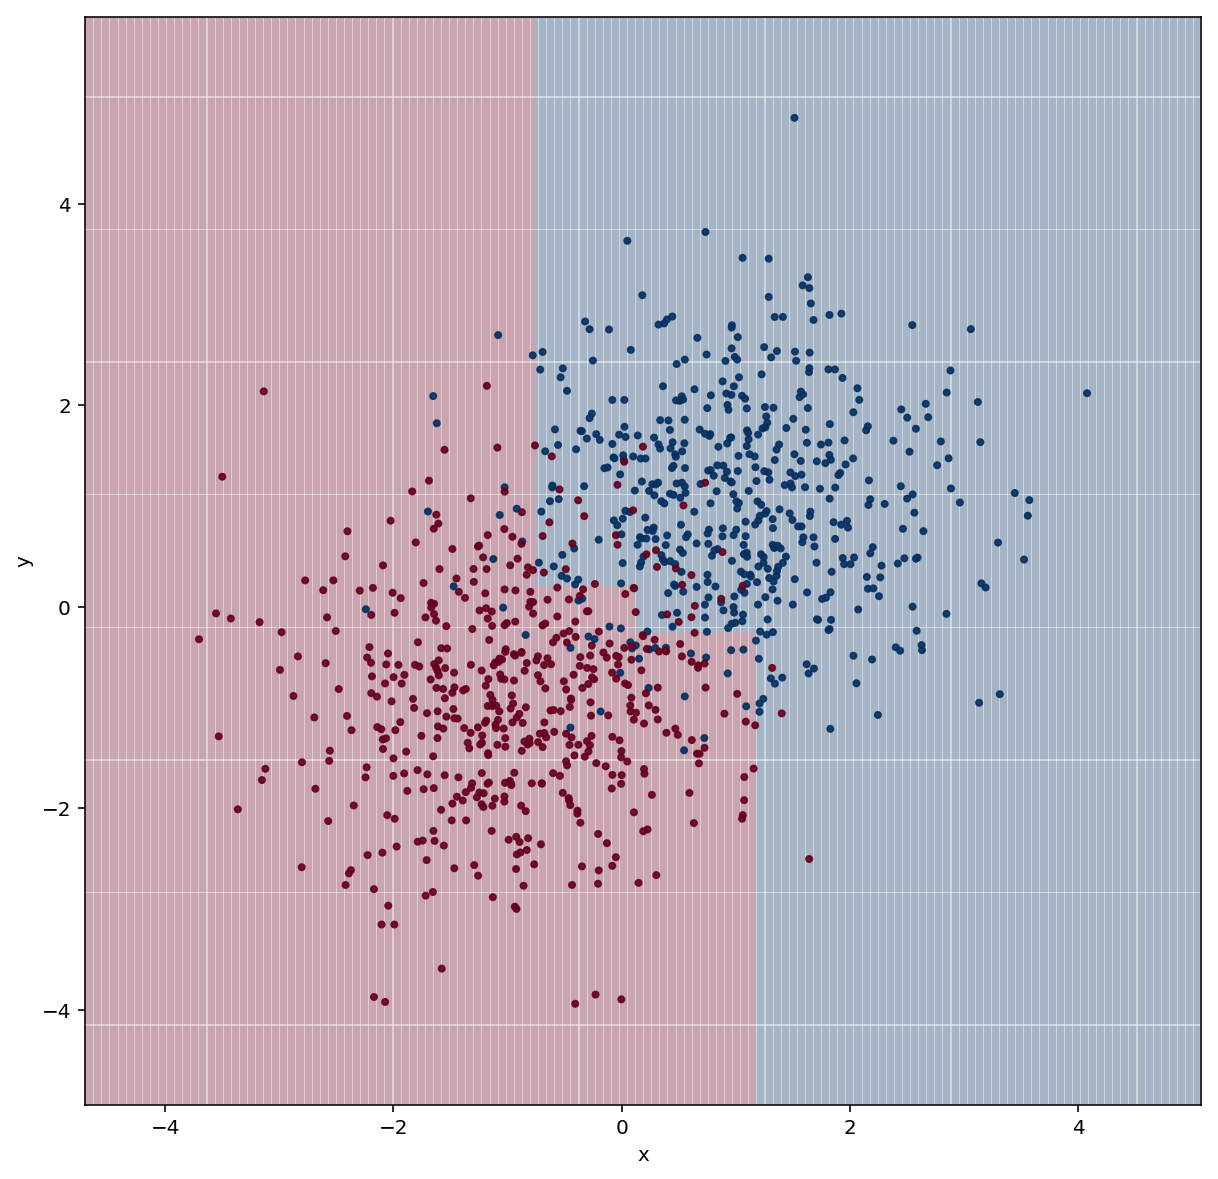

In [0]:
plot_predictions(x, y, CustomDecisionTreeClassifier(max_depth=3));

Дополнительная литература:
* Презентация Анны-Вероники Дорогуш про CatBoost, Computer Science Center: https://www.youtube.com/watch?v=UYDwhuyWYSo
* Немного описания про алгоритм построения дерева в LightGBM: https://lightgbm.readthedocs.io/en/latest/Features.html#optimization-in-accuracy
* Конспект лекции Соколова про решающие деревья: https://www.hse.ru/mirror/pubs/share/215285956
*  [Имплементация деревьев](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/tree/_tree.pxd) в Scikit-Learn
* Подробнее про ID3: http://www.saedsayad.com/decision_tree.htm